# Wstęp
Zadanie 7 stanowi wprowadzenie w tematykę transfer learning i wykorzystywania gotowych, publicznie udostępnianych modeli. W praktyce, dla zadań tak złożonych jak analiza obrazu, o wiele łatwiej jest dostosować istniejące już i wyuczone na dużych zbiorach danych modele do nowego zaadania, niż wyuczyć własny model od zera. Jako bardziej interesujący przykład zastosowania gotowych modeli zostanie pokazany też transfer stylu obrazów.

#Cel ćwiczenia

Celem ćwiczenia jest zapoznanie się z

*    mechanizmem importowania modeli
*    możliwościami wykorzystaniem transfer learningu do własnych zadań
*    transferem stylu jako przykładem wykorzystania cech z zamrożonej architektury

# Importowanie modeli

Importowanie w torchu realizować będziemy poprzez ładowanie zapisanego obiektu słownika z wszystkimi parametrami warstw. Warto pamiętać tutaj, że słownik ten nie zapamiętuje pełnej struktury sieci, a jedynie parametry! Dlatego z jednej strony dla wczytania gotowego modelu konieczne jest istnienie odpowiedniej architektury w kodzie (zaimplementowany `torch.nn.Module` realizujący tę architekturę). Z drugiej zaś, słownik parametrów zgodny pod względem nazw i kształtów parametrów z zadaną architekturą możemy wczytać do dowolnej, dostosowanej do naszych potrzeb klasy - w szczególności umożliwiając nam własną implementację `forward`. Na razie sprawdźmy model, który ma już swoją implementację w `torchvision`: klasyczną architekturę VGG.

In [1]:
import torch
import torchvision.models as models
from matplotlib import pyplot as plt


vgg19 = models.vgg19(pretrained=True)

print(vgg19)

c:\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\Piotr Szuba/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:15<00:00, 38.3MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

W kontekście vgg19, interesuje nas szczególnie moduł features: instancja `torch.nn.Sequential', obejmująca konwolucyjną część architektury. Dla nowych zadań analizy obrazów, możemy wykorzystać tę częśc z własnym klassyfikatorem.

In [2]:
print(vgg19.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Tutaj warto zwrócić jeszcze uwagę na przydatną własność `torch.nn.Sequential`: ta klasa jest indeksowalna, a kiedy korzystamy z indeksowania aby zwócić ciąg następujących po sobie elementów, zwracana jest również instancja `torch.nn.Sequential`:

In [3]:
print(f"pod indeksem 3 jest: {vgg19.features[3]}")
print(f"pod indeksami 3 do 7 jest: {vgg19.features[3:7]}")

pod indeksem 3 jest: ReLU(inplace=True)
pod indeksami 3 do 7 jest: Sequential(
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
)


# Zadanie 1

Zdefiniuj klasę LabVGG19, która inicjalizuje swoje parametry poprzez wczytanie wyuczonego modelu z torchvision.models, ale jej `forward` zwraca na wyjściu krotkę lub listę `out` gdzie



*   `out[0]` - cechy z poziomu architektury poprzedzającego pierwszy Max Pooling
*    `out[1]` - cechy z poziomu architektury poprzedzającego drugi Max Pooling
*    `out[2]` - cechy z poziomu architektury poprzedzającego trzeci Max Pooling


In [4]:
class LabVGG19(torch.nn.Module):
  def __init__(self):
    super().__init__()
    vgg19 = models.vgg19(pretrained=True)
    features = vgg19.features

    self.layer1 = torch.nn.Sequential(*features[:4])
    self.layer2 = torch.nn.Sequential(*features[4:9])
    self.layer3 = torch.nn.Sequential(*features[9:18])
    
  def forward(self, x):
      out1 = self.layer1(x)
      out2 = self.layer2(out1)
      out3 = self.layer3(out2)

      return out1, out2, out3

Zweryfikuj działanie architektury

In [7]:
model = LabVGG19()
dummy_input = torch.zeros((3,3,32,32)).cuda()
out = model(dummy_input)

assert(out[0].shape == (3,64,32,32))
assert(out[1].shape == (3,128,16,16))
assert(out[2].shape == (3,256,8,8))

c:\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

# Transfer Learning

Mając możliwość wydobywania cech z dowolnego poziomu architektury, możemy łatwo wykorzystać je do dowolnych nowych zadań. Wystarczy zbudować model, który przetwarza jako wejście to, co wynika z naszego wcześniejszego przetwarzania przez wyuczoną już sieć. Zaimportowaną część sieci możemy zarówno **douczać** jak i **zamrozić** w zależności od tego czy jej parametry podamy przy naszym uczeniu do optymalizowania. W tym drugim przypadku, warto pamiętać o wyłączeniu gradientów dla zamrożonych warstw.

Poniżej kod pomocniczy z laboratorium 3, można zastąpić go własną implementacją pętli uczącej uwzględniającej ulepszenia wykonane na laboratoriach 4 i 5. W zadaniach poniżej wystarczy porównać końcowy wynik uczenia, nie jest wymagane wyrysowywanie pełnych krzywych w tensorboard niemniej mogą one pomóc w analizie otrzymanych wyników.


**VGG na wejściu oczekuje danych znormalizowanych, z określonymi wartościami średniej i odchylenia standardowego. Transformacja wejściowa powinna korzystać z `transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))`.**

In [53]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from typing import Tuple
from tqdm import tqdm
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
test_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, train=False, download=True)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)


def count_correct(
    y_pred: torch.Tensor, y_true: torch.Tensor
) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()


def validate(
    model: nn.Module, 
    loss_fn: torch.nn.CrossEntropyLoss, 
    dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch.cuda())

        if isinstance(model, LabVGG19):
            _, _, y_pred = y_pred
            y_pred = y_pred.view(y_pred.size(0), -1)

        all += len(y_pred)
        loss += loss_fn(y_pred, y_batch.cuda()).sum()
        correct += count_correct(y_pred, y_batch.cuda())
    return loss / all, correct / all


def fit(
    model: nn.Module, optimiser: optim.Optimizer, 
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader, 
    val_dl: DataLoader, epochs: int, 
    print_metrics: str = True
):
  val_accs = []
  for epoch in range(epochs):
      for X_batch, y_batch in tqdm(train_dl):
          y_pred = model(X_batch.cuda())

          if isinstance(model, LabVGG19):
              _, _, y_pred = y_pred
              y_pred = y_pred.view(y_pred.size(0), -1)

          loss = loss_fn(y_pred, y_batch.cuda())

          loss.backward()
          optimiser.step()
          optimiser.zero_grad()

      if print_metrics: 
          model.eval()
          with torch.no_grad():
              train_loss, train_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=train_dl
              ) 
              val_loss, val_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=val_dl
              )
              val_accs.append(val_acc)
              print(
                  f"Epoch {epoch}: "
                  f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                  f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
              )
  return val_accs


def plot_scores(scores_list: list[tuple[list[torch.Tensor], str]]):
    plt.figure(figsize=(10, 6))
    lines = []
    for score, label in scores_list:
        (line,) = plt.plot([tensor.cpu() for tensor in score], label=label)
        lines.append(line)
    plt.title("accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("score")
    plt.legend(lines, [l.get_label() for l in lines], loc="best")
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


# Zadanie 2

Zaimplementuj model korzystający z cech wyjściowych na pierwszym, drugim i trzecim poziomie zwracanym przez LabVGG19. (Wykorzystaj Adaptive Pooling aby uniknąć gigantycznej wymiarowości wynikającej ze spłaszczania na tych poziomach). Porównaj wyniki tego modelu na CIFAR10 w wariantach: zamrożonych warstw konwolucyjnych i z douczaniem warstw konwolucyjnych.

Uwaga: zadania 2 i 3 będą wymagały więcej czasu przetwarzania niż wysiłku intelektualnego, więc polecane jest wykonanie ich jako ostatnich, a na zajęciach - przejście do punktu Transfer Stylu.

In [22]:
class CustomModel(torch.nn.Module):
    def __init__(self, pretrained: bool = True):
        super().__init__()
        self.labvgg19 = LabVGG19()
        
        if pretrained:
            for param in self.labvgg19.parameters():
                param.requires_grad = False

        self.avg_pool1 = nn.AdaptiveAvgPool2d((1, 1))
        self.avg_pool2 = nn.AdaptiveAvgPool2d((1, 1))
        self.avg_pool3 = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc = nn.Linear(64 + 128 + 256, 10)

    def forward(self, x):
        out1, out2, out3 = self.labvgg19(x)
        
        out1 = self.avg_pool1(out1)
        out2 = self.avg_pool2(out2)
        out3 = self.avg_pool3(out3)
        
        out1 = out1.view(out1.size(0), -1)
        out2 = out2.view(out2.size(0), -1)
        out3 = out3.view(out3.size(0), -1)
        
        out = torch.cat((out1, out2, out3), dim=1)
        
        return self.fc(out)

In [37]:
model_frozen = CustomModel().cuda()
model_unfrozen = CustomModel(pretrained=False).cuda()

loss_fn = nn.CrossEntropyLoss()
optim_frozen = optim.Adam(model_frozen.fc.parameters(), lr=1e-4)
optim_unfrozen = optim.Adam(model_unfrozen.parameters(), lr=1e-4)

print("Training with frozen convolutional layers:")
val_accs_frozen = fit(model_frozen, optim_frozen, loss_fn, train_dl, test_dl, epochs=10)

print("\nTraining with unfrozen convolutional layers:")
val_accs_unfrozen = fit(model_unfrozen, optim_unfrozen, loss_fn, train_dl, test_dl, epochs=10)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training with frozen convolutional layers:


100%|██████████| 1563/1563 [00:23<00:00, 66.03it/s]


Epoch 0: train loss = 0.034 (acc: 0.645), validation loss = 0.035 (acc: 0.638)


100%|██████████| 1563/1563 [00:22<00:00, 68.01it/s]


Epoch 1: train loss = 0.030 (acc: 0.689), validation loss = 0.030 (acc: 0.681)


100%|██████████| 1563/1563 [00:24<00:00, 64.36it/s]


Epoch 2: train loss = 0.027 (acc: 0.717), validation loss = 0.027 (acc: 0.709)


100%|██████████| 1563/1563 [00:24<00:00, 64.29it/s]


Epoch 3: train loss = 0.025 (acc: 0.732), validation loss = 0.026 (acc: 0.723)


100%|██████████| 1563/1563 [00:26<00:00, 59.85it/s]


Epoch 4: train loss = 0.024 (acc: 0.742), validation loss = 0.025 (acc: 0.732)


100%|██████████| 1563/1563 [00:22<00:00, 69.26it/s]


Epoch 5: train loss = 0.024 (acc: 0.749), validation loss = 0.024 (acc: 0.738)


100%|██████████| 1563/1563 [00:22<00:00, 68.87it/s]


Epoch 6: train loss = 0.023 (acc: 0.755), validation loss = 0.024 (acc: 0.745)


100%|██████████| 1563/1563 [00:26<00:00, 58.16it/s]


Epoch 7: train loss = 0.023 (acc: 0.759), validation loss = 0.023 (acc: 0.750)


100%|██████████| 1563/1563 [00:22<00:00, 68.72it/s]


Epoch 8: train loss = 0.022 (acc: 0.761), validation loss = 0.023 (acc: 0.752)


100%|██████████| 1563/1563 [00:23<00:00, 67.74it/s]


Epoch 9: train loss = 0.022 (acc: 0.766), validation loss = 0.022 (acc: 0.758)

Training with unfrozen convolutional layers:


100%|██████████| 1563/1563 [00:25<00:00, 61.00it/s]


Epoch 0: train loss = 0.014 (acc: 0.848), validation loss = 0.017 (acc: 0.817)


100%|██████████| 1563/1563 [00:23<00:00, 66.85it/s]


Epoch 1: train loss = 0.009 (acc: 0.899), validation loss = 0.013 (acc: 0.857)


100%|██████████| 1563/1563 [00:22<00:00, 68.52it/s]


Epoch 2: train loss = 0.008 (acc: 0.919), validation loss = 0.013 (acc: 0.864)


100%|██████████| 1563/1563 [00:23<00:00, 67.01it/s]


Epoch 3: train loss = 0.007 (acc: 0.927), validation loss = 0.013 (acc: 0.861)


100%|██████████| 1563/1563 [00:22<00:00, 68.38it/s]


Epoch 4: train loss = 0.004 (acc: 0.962), validation loss = 0.012 (acc: 0.877)


100%|██████████| 1563/1563 [00:22<00:00, 69.18it/s]


Epoch 5: train loss = 0.004 (acc: 0.959), validation loss = 0.013 (acc: 0.868)


100%|██████████| 1563/1563 [00:22<00:00, 68.83it/s]


Epoch 6: train loss = 0.002 (acc: 0.981), validation loss = 0.012 (acc: 0.885)


100%|██████████| 1563/1563 [00:22<00:00, 68.62it/s]


Epoch 7: train loss = 0.002 (acc: 0.983), validation loss = 0.013 (acc: 0.884)


100%|██████████| 1563/1563 [00:22<00:00, 68.73it/s]


Epoch 8: train loss = 0.001 (acc: 0.990), validation loss = 0.013 (acc: 0.891)


100%|██████████| 1563/1563 [00:23<00:00, 67.60it/s]


Epoch 9: train loss = 0.001 (acc: 0.987), validation loss = 0.013 (acc: 0.887)


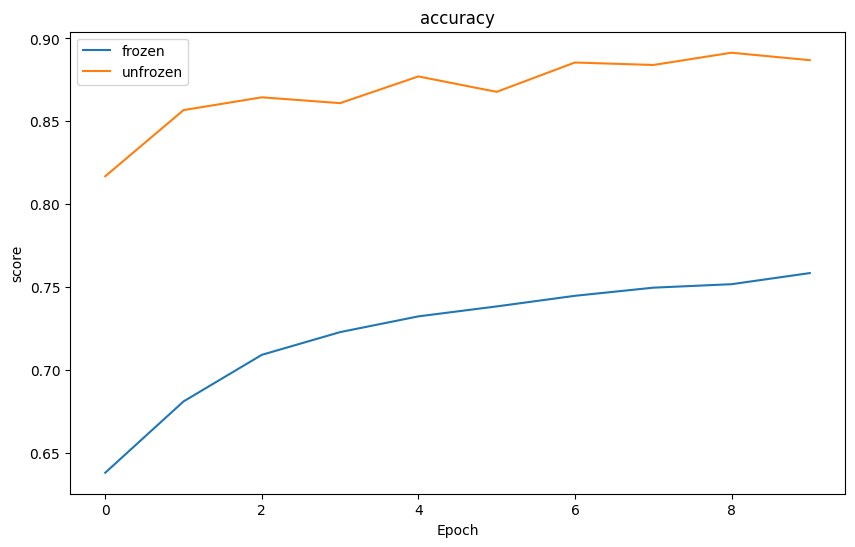

In [38]:
plot_scores([(val_accs_frozen, "frozen"), (val_accs_unfrozen, "unfrozen")])

# Zadanie 3

Spróbuj wydobyć cechy za pomocą samodzielmnie wybranego modelu dostępnego w `torchvision.models` (innego niż VGG) a następnie wyuczyć model MLP oparty o cechy na wyjściu konwolucyjnej części całej architektury. Porównaj wynik z tymi, które uzyskała sieć oparta o LabVGG19.

In [34]:
from torchvision.models import resnet18

class CustomResNet18(torch.nn.Module):
    def __init__(self):
        super().__init__()
        resnet = resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.features(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [57]:
model_resnet18 = CustomResNet18().cuda()
model_lab = LabVGG19().cuda()

loss_fn = nn.CrossEntropyLoss()
optim_resnet18 = optim.Adam(model_resnet18.parameters(), lr=1e-4)
optim_lab = optim.Adam(model_lab.parameters(), lr=1e-4)

print("Training with ResNet-18 based model:")
val_accs_resnet18 = fit(model_resnet18, optim_resnet18, loss_fn, train_dl, test_dl, epochs=10)

print("\nTraining with LabVGG19 based model:")
val_accs_lab = fit(model_lab, optim_lab, loss_fn, train_dl, test_dl, epochs=10)

Training with ResNet-18 based model:


100%|██████████| 1563/1563 [00:30<00:00, 51.92it/s]


Epoch 0: train loss = 0.017 (acc: 0.817), validation loss = 0.021 (acc: 0.766)


100%|██████████| 1563/1563 [00:28<00:00, 54.62it/s]


Epoch 1: train loss = 0.014 (acc: 0.843), validation loss = 0.020 (acc: 0.788)


100%|██████████| 1563/1563 [00:29<00:00, 52.67it/s]


Epoch 2: train loss = 0.012 (acc: 0.863), validation loss = 0.020 (acc: 0.790)


100%|██████████| 1563/1563 [00:28<00:00, 54.13it/s]


Epoch 3: train loss = 0.007 (acc: 0.921), validation loss = 0.017 (acc: 0.818)


100%|██████████| 1563/1563 [00:30<00:00, 52.03it/s]


Epoch 4: train loss = 0.006 (acc: 0.945), validation loss = 0.018 (acc: 0.817)


100%|██████████| 1563/1563 [00:28<00:00, 54.17it/s]


Epoch 5: train loss = 0.004 (acc: 0.959), validation loss = 0.019 (acc: 0.824)


100%|██████████| 1563/1563 [00:28<00:00, 53.91it/s]


Epoch 6: train loss = 0.003 (acc: 0.966), validation loss = 0.020 (acc: 0.822)


100%|██████████| 1563/1563 [00:28<00:00, 54.78it/s]


Epoch 7: train loss = 0.002 (acc: 0.976), validation loss = 0.022 (acc: 0.820)


100%|██████████| 1563/1563 [00:29<00:00, 52.86it/s]


Epoch 8: train loss = 0.003 (acc: 0.968), validation loss = 0.023 (acc: 0.812)


100%|██████████| 1563/1563 [00:28<00:00, 54.54it/s]


Epoch 9: train loss = 0.002 (acc: 0.975), validation loss = 0.025 (acc: 0.819)

Training with LabVGG19 based model:


100%|██████████| 1563/1563 [00:21<00:00, 73.36it/s]


Epoch 0: train loss = 0.036 (acc: 0.606), validation loss = 0.038 (acc: 0.581)


100%|██████████| 1563/1563 [00:21<00:00, 71.87it/s]


Epoch 1: train loss = 0.027 (acc: 0.705), validation loss = 0.031 (acc: 0.661)


100%|██████████| 1563/1563 [00:21<00:00, 71.37it/s]


Epoch 2: train loss = 0.020 (acc: 0.780), validation loss = 0.026 (acc: 0.715)


100%|██████████| 1563/1563 [00:21<00:00, 74.01it/s]


Epoch 3: train loss = 0.017 (acc: 0.819), validation loss = 0.025 (acc: 0.727)


100%|██████████| 1563/1563 [00:21<00:00, 71.54it/s]


Epoch 4: train loss = 0.013 (acc: 0.862), validation loss = 0.025 (acc: 0.734)


100%|██████████| 1563/1563 [00:21<00:00, 72.27it/s]


Epoch 5: train loss = 0.009 (acc: 0.912), validation loss = 0.024 (acc: 0.755)


100%|██████████| 1563/1563 [00:21<00:00, 72.04it/s]


Epoch 6: train loss = 0.005 (acc: 0.952), validation loss = 0.026 (acc: 0.758)


100%|██████████| 1563/1563 [00:22<00:00, 70.02it/s]


Epoch 7: train loss = 0.004 (acc: 0.966), validation loss = 0.028 (acc: 0.757)


100%|██████████| 1563/1563 [00:21<00:00, 71.32it/s]


Epoch 8: train loss = 0.003 (acc: 0.972), validation loss = 0.032 (acc: 0.752)


100%|██████████| 1563/1563 [00:21<00:00, 71.66it/s]


Epoch 9: train loss = 0.002 (acc: 0.980), validation loss = 0.034 (acc: 0.750)


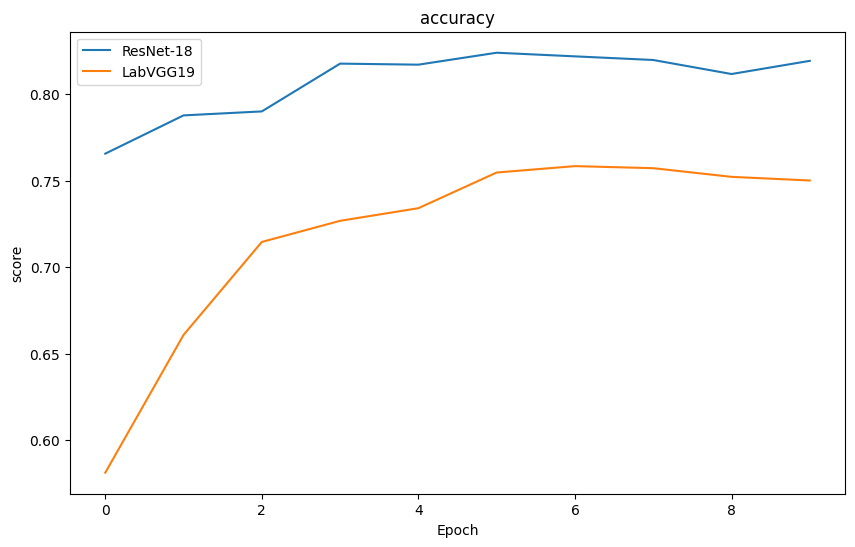

In [58]:
plot_scores([(val_accs_resnet18, "ResNet-18"), (val_accs_lab, "LabVGG19")])

# Transfer stylu

Jedną z ciekawszych demonstracji tego, jak wykorzystać można cechy wyciągane z gotowego modelu jest tzw. transfer stylu - jedno z klasycznych "pokazowych" zastosowań głębokiego uczenia. Tutaj spróbujemy najprostszego podejścia, o wąskiej definicji stylu obejmującej właściwości tekstury obrazu. Bardziej zaawansowane opcje obejmują zastosowania sieci GAN, czy deformacje kształtu oparte o punkty kluczowe, a to już materiał na inny kurs.

Transfer stylu opisany został w roku 2015, w publikacji *A Neural Algorithm of Artistic Style*

https://arxiv.org/abs/1508.06576

To oryginalne, najbardziej klasyczne podejście opiera się optymalizację w przestrzeni obrazu. Parametrem nie jest tutaj sieć, ale właśnie obrazek który próbujemy stworzyć. Dla zadanego obrazka definiującego treść i obrazka definiującego styl skorzystamy z cech zwróconych przez sieć VGG, aby obliczyć dwie funkcje kosztu - koszt treści i stylu. Następnie będziemy optymalizować generowany obraz tak, aby zminimalizować koszt treści względem obrazu określającego pożądaną treść, oraz zminimalizować koszt stylu względem obrazu określającego pożądany styl. Efektem, jeśli wszystko się uda, będzie nowe dzieło, przedstawiające treść obrazka pierwszego *w stylu* obrazka drugiego.

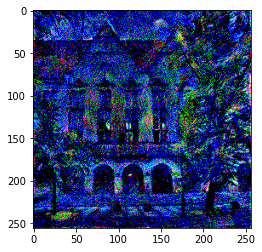

Jak zdefiniować koszt treści? Tutaj rozwiązanie jest proste - błąd średniokwadratowy pomiędzy cechami zwróconymi przez VGG z obrazu docelowego, a tymi zwróconymi z obrazu optymalizowanego. Chcemy żeby nasz obrazek zawierał tę samą treść, a więc oczekujemy, że jego cechy wykrywane przez wyuczony na zadaniu rozpoznawania obiektów model będą podobne.




In [13]:
import torch.nn.functional as F

def content_loss(content_features, input_features):
  return F.mse_loss(content_features, input_features)

Styl/tekstura to trochę bardziej skomplikowane pojęcie. W tym przypadku będziemy o nim myśleć w kategorii rozkładu cech występujących na całej powierzchni obrazu, niezależnie od położenia. Autorzy klasycznego podejścia wybrali jako matematyczny obiekt opisujący ten rozkład macierz Grama:

https://en.wikipedia.org/wiki/Gramian_matrix

Macierz taka jest własnością pewnego zbioru wektorów i aby przybliżyć jej definicję, zamiast korzystać ze wzorów spójrzmy po prostu na implementację:

In [12]:
def calculate_gram_matrices(feature_tensor):
  # zakładamy paczkę map cech na wejściu - a to wymiar batcha
  a,b,c,d = feature_tensor.shape
  reshaped_features = feature_tensor.view(a,b,c*d)
  # wyjście ma wymiar (a,b,b) - jest paczką macierzy
  return torch.matmul(reshaped_features, reshaped_features.transpose(1,2))

Powyższy kod zwraca dla batcha wejściowego, batch macierzy Grama. Możemy myśleć o macierzy Grama jako o obiekcie powiązanym z *macierzą kowariancji* rozkładu cech. Istotne różnice: wektory przy wyliczaniu macierzy Grama nie są przesunięte o średnią, zaś wynik nie jest dzielony przez liczbę punktów, więc nie jest to wartość oczekiwana. To ta druga różnica sprawia, że mówimy o własności *zbioru wektorów* zamiast o własności *rozkładu* - bo elementy macierzy Grama będą zwiększać się z większą liczbą uwzględnionych punktów.
(Naszym zbiorem będzie w tym przypadku *zbiór wszystkich pikseli w danej mapie cech*.) Jeżeli jednak wykorzystujemy obrazy treści i stylu o tym samym rozmiarze co rozmiar obrazu generowanego, ta różnica staje się pomijalna.

Stąd łatwo już przejść do definicji kosztu: kosztem stylu będzie błąd średniokwadratowy pomiędzy macierzami grama opisującymi odpowiednie mapy cech:



In [11]:
def style_loss(style_features, input_features):
  return F.mse_loss(calculate_gram_matrices(style_features), calculate_gram_matrices(input_features))

Pozostaje pytanie, na jakim poziomie wyciągać z architektury cechy? Tutaj jednoznacznej odpowiedzi nie ma, acz typowo stylu szukać będziemy na niższych poziomach, niż treści. W praktyce jednak najlepsze wyniki osiągniemy, próbując dopasować rozwiązanie do konkretnej pary obrazów styl/treść i konkrentej rozdzielczości.

Jescze jedna uwaga na koniec: zauważ, że transfer stylu jest dobrym przykladem zadania gdzie **zawsze** będziemy zamrażać architekturę wydobywającą cechy. Dlaczego? Douczanie ekstraktora cech ułatwiałoby osiągnięcie optimum funkcji kosztu (patrząc na samą wartość). Ale w żaden sposób nie zapewnialibyśmy przy tym, że wydobywane cechy dalej mają coś wspólnego z semantycznymi cechami obrazu. Globalnym optimum w przestrzeni parametrów: obrazu i sieci, byłby ekstraktor który niezależnie od wejścia, zeruje wartości wszystkich cech!

# Zadanie 4

Zaimplementuj transfer stylu, wykorzystując LabVGG19 aby otrzymać cechy na różnych poziomach architektury. Algorytm transferu stylu powinien wykonywać `num_steps` kroków optymalizatora LBFGS, optymalizującego obrazek `input_img` względem kosztów stylu i treści. Koszty stylu i treści powinny być wyliczane na wybieranym parametrem poziomie architektury. Po zakończeniu wyświetl wygenerowany obraz.

Pamiętając, że koszty: stylu i treści można wyliczac na różnych poziomach architektury oraz z różnymi wagami, spróbuj dopasować te aspekty algorytmu aby uzyskać interesujący wizualnie efekt.

In [59]:
from PIL import Image
import numpy as np

imsize = (128,128)

def extract_features(image: torch.Tensor, model):
    out = model(image)
    features = [out[0], out[1], out[2]]
    return features

def image_loader(image_name: str): #
    image = Image.open(image_name)
    transform = transforms.Compose([
      transforms.Resize(imsize),  
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) 
    return transform(image).unsqueeze(0)


def image_unloader(tensor: torch.Tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image


def run_style_transfer(content_img, style_img, input_img, num_steps=300, content_weight=1, style_weight=1000000):
    model = LabVGG19().cuda()
    
    content_features = extract_features(content_img, model)
    style_features = extract_features(style_img, model)
    
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    
    def closure():
        optimizer.zero_grad()
        
        input_features = extract_features(input_img, model)
        content_loss_value = content_loss(content_features[-1], input_features[-1])
        style_loss_value = 0

        for i in range(len(style_features)):
            style_loss_value += style_loss(style_features[i], input_features[i])

        total_loss = content_weight * content_loss_value + style_weight * style_loss_value
        total_loss.backward(retain_graph=True)

        return total_loss
    
    for i in range(num_steps):
        optimizer.step(closure)
        
    return input_img

style_img_path = "styles.jpg"
content_img_path = "Smiley.png"

input_img = torch.randn(8, 3, imsize[0], imsize[1]).cuda()
style_img = image_loader(style_img_path).cuda()
content_img = image_loader(content_img_path).cuda()

output_img = run_style_transfer(content_img, style_img, input_img, num_steps=300)

<ipython-input-13-2a52db0e2019>:4: UserWarning: Using a target size (torch.Size([8, 256, 32, 32])) that is different to the input size (torch.Size([1, 256, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(content_features, input_features)
<ipython-input-11-3690ba1b8b74>:2: UserWarning: Using a target size (torch.Size([8, 64, 64])) that is different to the input size (torch.Size([1, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(calculate_gram_matrices(style_features), calculate_gram_matrices(input_features))
<ipython-input-11-3690ba1b8b74>:2: UserWarning: Using a target size (torch.Size([8, 128, 128])) that is different to the input size (torch.Size([1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(calculate_gram_matrices(style_

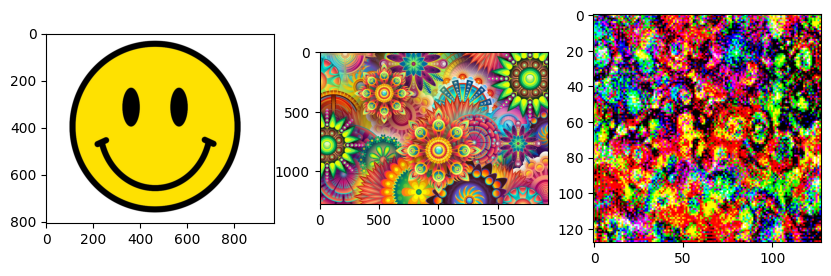

In [60]:
image = np.transpose(output_img[0].detach().cpu().numpy(), (1, 2, 0))
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
axes[0].imshow(np.array(Image.open("Smiley.png")))
axes[1].imshow(np.array(Image.open("styles.jpg")))
axes[2].imshow(image)
plt.show()